In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from math import gcd
from numpy.random import randint
from numpy.random import seed
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap([qubit], [n-qubit-1])
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h([j])
    qc.name = "QFT†"
    return qc

In [3]:
def controlled_draper_adder(a,n):
    
    a_bin = [int(x) for x in bin(a)[2:]]
    a_bin.reverse()
    a_bin = (a_bin + n * [0])[:n]
    a_bin.reverse()
    
    qc = QuantumCircuit(n+1)
    
    qc.append(qft_dagger(n).inverse(),[1+i for i in range(n)])
    
    for i in range(n):
        for j in range(n-i):
            if a_bin[i+j] == 1:
                qc.crz(2*np.pi/pow(2,j+1),0,1+i)
    
    qc.append(qft_dagger(n),[1+i for i in range(n)])
    
    qc.name = "%i_adder_%i_qubit" % (a,n)
    
    return qc

In [4]:
qc = controlled_draper_adder(3,3)
#qc.draw('text')

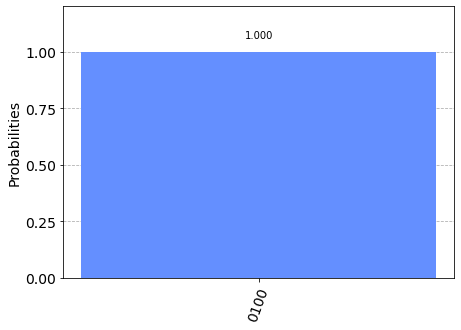

In [5]:
a = 7
b = 4
c = 0
n = 4

b_bin = [int(x) for x in bin(b)[2:]]
b_bin.reverse()

adder_n_qubit_test = QuantumCircuit(n+1,n)

## Initialize b and control

if c == 1:
    adder_n_qubit_test.x([0])

for i in range(len(b_bin)):
    if b_bin[i] == 1:
        adder_n_qubit_test.x([1+i])
        
## Insert adder

adder_n_qubit_test.append(controlled_draper_adder(a,n),[i for i in range(n+1)])

## Measure b

adder_n_qubit_test.measure([1+i for i in range(n)],[i for i in range(n)])

adder_n_qubit_test.draw('text')

## Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(adder_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [6]:
#############################################################################################
#Computes sum of n-bit numbers a and b modular-N and stores result in b if control bit is one
#a is not an input but a classical value which determines circuit topology
#############################################################################################

def modular_adder_n_qubit(a,N,n):
    
    ## Converting decimal N to binary list
    
    z = [int(x) for x in bin(N)[2:]]
    z.reverse()
    
    qc = QuantumCircuit(n+3)
    
    qc.x([n+2])
    
    ## Compute sum of a and b
    
    qc.append(controlled_draper_adder(a,n+1),[i for i in range(n+2)])
    
    ## Substract N by using inverse addition block
    
    qc.append(controlled_draper_adder(N,n+1).inverse(),[n+2] + [1+i for i in range(n+1)])
    
    ## If an overflow occurs (e.g. a+b-N<0) add N
    # Overflow is indicated by the most significant bit of b
    # This value is stored in a temporary bit t
    
    qc.x([n+1])
    qc.cx([n+1],[n+2])
    qc.x([n+1])
    
    # If t indicates an overflow, N is added back

    qc.append(controlled_draper_adder(N,n+1),[n+2] + [1+i for i in range(n+1)])
        
    ## Reset temporary bit t to zero
    
    qc.append(controlled_draper_adder(a,n+1).inverse(),[i for i in range(n+2)])
    qc.cx([n+1],[n+2])
    qc.append(controlled_draper_adder(a,n+1),[i for i in range(n+2)])
    qc.x([n+2])
    
    qc.name = "%i_modular_%i_adder_%i_qubit" %(a,N,n)
    return qc

In [7]:
qc = modular_adder_n_qubit(3,7,3)
#qc.draw('text')

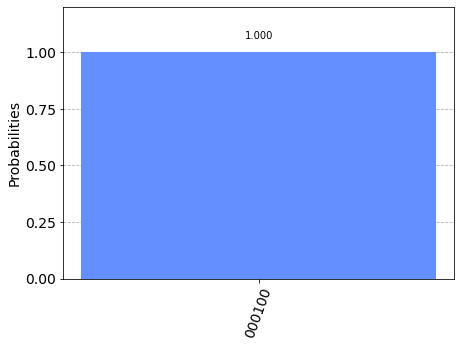

In [8]:
##############################################
# Test code n-qubit modular adder
##############################################

c=1
a=7
b=8
N=11
n=4

## Convert decimal number to binary list

b_bin = [int(x) for x in bin(b)[2:]]
b_bin.reverse()

modular_adder_n_qubit_test = QuantumCircuit(n+3,n+2)

## Initialize b and control

if c == 1:
    modular_adder_n_qubit_test.x([0])

for i in range(len(b_bin)):
    if b_bin[i] == 1:
        modular_adder_n_qubit_test.x([1+i])
        
## Insert modular adder

modular_adder_n_qubit_test.append(modular_adder_n_qubit(a,N,n),[i for i in range(n+3)])

## Measure b

modular_adder_n_qubit_test.measure([1+i for i in range(n+1)] + [n+2],[i for i in range(n+2)])

modular_adder_n_qubit_test.draw('text')

##Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(modular_adder_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [9]:
############################################################################################################
# Computes modular multiplication of two n-bit number z and m and stores result in b if control bit c is one
# Stores z in b if c is zero
# m is not an input but a classical value which determines circuit topology
############################################################################################################

def modular_multiplicator_n_qubit(m,N,n):
        
    qc = QuantumCircuit(2*n+4)
    
    ## Add m^(2^i) mod N if zi and c are one for every bit of z
    
    for i in range(n):
        #Compute m^(2^i) mod N
        a = m*pow(2,i) % N
        #Perform modular addition if c and zi are one
        qc.ccx([0],[1+i],[n+1])
        qc.append(modular_adder_n_qubit(a,N,n),[n+1+x for x in range(n+3)])
        #Reset control bit of modular adder
        qc.ccx([0],[1+i],[n+1])
                
    ## Store z in b if c is zero
    
    qc.x([0])
    for i in range(n):
        qc.ccx([0],[1+i],[n+2+i])
    qc.x([0])
    
    qc.name = "%i_modular_%i_multiplicator_%i_qubit" %(m,N,n)
    return qc

In [10]:
qc = modular_multiplicator_n_qubit(3,5,3)
#qc.draw('text')

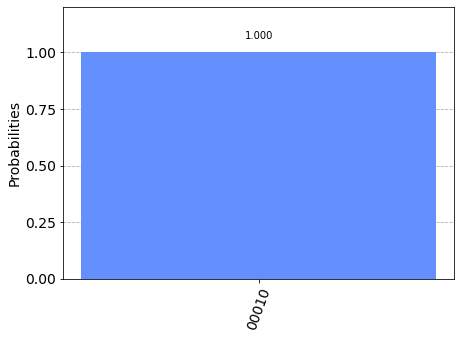

In [11]:
######################################
# Test code n-qubit modular multiplier
######################################

c=1
z=5
m=7
N=11
n=4

## Convert decimal number to binary list

z_bin = [int(x) for x in bin(z)[2:]]
z_bin.reverse()

modular_multiplicator_n_qubit_test = QuantumCircuit(2*n+4,n+1)

## Initialize c and z

if c == 1:
    modular_multiplicator_n_qubit_test.x([0])
for i in range(len(z_bin)):
    if z_bin[i] == 1:
        modular_multiplicator_n_qubit_test.x(1+i)
        
## Insert modular multiplicator

modular_multiplicator_n_qubit_test.append(modular_multiplicator_n_qubit(m,N,n),[i for i in range(2*n+4)])

## Measure b

modular_multiplicator_n_qubit_test.measure([n+2+i for i in range(n+1)],[i for i in range(n+1)])

modular_multiplicator_n_qubit_test.draw('text')

##Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(modular_multiplicator_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [12]:
######################################################################################
# Computes y^x mod N and stores result in z where y is an n-bit and x a 2-n bit number
# y is not an input but a classical value which determines circuit topology
######################################################################################

def modular_exponentiator_n_qubit(N,y,n):
    
    qc = QuantumCircuit(4*n+3)
    
    ## Multiply by y^(2^i)*xi for every bit of x
    
    for q in range(2*n):
        # Performing multiplication
        qc.append(modular_multiplicator_n_qubit(pow(y,pow(2,q)),N,n),[q] + [2*n+i for i in range(2*n+3)])
        # Swapping z with b
        for r in range(n):
            qc.cswap([q],[2*n+r],[3*n+1+r])
        # Resetting b to zero
        qc.append(modular_multiplicator_n_qubit(pow(pow(y,pow(2,q)),-1,N),N,n).inverse(),[q] + [2*n+i for i in range(2*n+3)])
        
    qc.name = "%i_modular_%i_exponentiator_%i_qubit" %(y,N,n)
    return qc

In [13]:
qc = modular_exponentiator_n_qubit(15,2,4)
#qc.draw('text')

In [15]:
###########################################################
#Authentication Code Needed for the Quantum-Inspire Backend
###########################################################
import os
from getpass import getpass
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute

from quantuminspire.qiskit import QI

QI_EMAIL = os.getenv('QI_EMAIL')
QI_PASSWORD = os.getenv('QI_PASSWORD')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
    
token = load_account()
if token is not None:
    authentication = get_token_authentication(token)
else:
    if QI_EMAIL is None or QI_PASSWORD is None:
        print('Enter email')
        email = input()
        print('Enter password')
        password = getpass()
    else:
        email, password = QI_EMAIL, QI_PASSWORD
    authentication = get_basic_authentication(email, password)

QI.set_authentication(authentication, QI_URL)
qi_backend = QI.get_backend('QX single-node simulator')

In [37]:
######################################################################
# Code for the shors algorithm with Quantum-Inspire backend
######################################################################


z=1
N=15
seed(9)
y= randint(2, N - 1)
b = np.gcd(y,N)
print(y)

if b != 1: #y is not coprime with N, so the gcd of y is a factor of N
    print('The prime numbers forming N = %i are:' %N, [b,int(N/b)])
else:
    n=len([int(i) for i in bin(N)[2:]])

    ## Convert decimal number to binary list
    N_bin = [int(i) for i in bin(N)[2:]]

    z_bin = [int(i) for i in bin(z)[2:]]

    z_bin.reverse()
    N_bin.reverse()

    circuit = QuantumCircuit(4*n+3)

    ## Initialise in a superposition and initialisation of z 
    ## dont worry if you think its stuck, this part does take forever :/
    for i in range(2*n):
        circuit.h([i])

    for i in range(len(z_bin)):
        if z_bin[i] == 1:
            circuit.x([2*n+i])

    for i in range(len(N_bin)):
        if N_bin[i] == 1:
            circuit.x([3*n+2+i])



    ## Insert modular exponentiator

    circuit.append(modular_exponentiator_n_qubit(N,y,n),[i for i in range(4*n+3)])

    ## Insert QFT

    circuit.append(qft_dagger(2*n),[i for i in range(2*n)])


    ##Simulate

    y_meas = ClassicalRegister(2*n, "y_out")
    circuit.add_register(y_meas)
    circuit.measure([i for i in range(2*n)],y_meas)

    qi_job = execute(circuit, backend=qi_backend, shots=2048)
    result = qi_job.result()

    histogram = result.get_counts(circuit)
    print(histogram.items())

7
dict_items([('00000000', 260), ('00000101', 1), ('00001011', 14), ('00001101', 6), ('00001111', 2), ('00010011', 14), ('00010101', 36), ('00010111', 5), ('00011001', 3), ('00011011', 19), ('00011101', 5), ('00100011', 5), ('00100101', 17), ('00100111', 12), ('00101001', 9), ('00101011', 35), ('00101101', 16), ('00110011', 8), ('00110101', 14), ('00111001', 1), ('00111011', 1), ('01000000', 257), ('01000101', 2), ('01000111', 2), ('01001001', 2), ('01001011', 17), ('01001101', 9), ('01010011', 14), ('01010101', 41), ('01010111', 9), ('01011001', 10), ('01011011', 13), ('01011101', 2), ('01100011', 2), ('01100101', 16), ('01100111', 6), ('01101001', 10), ('01101011', 32), ('01101101', 21), ('01101111', 1), ('01110011', 15), ('01110101', 17), ('01110111', 1), ('01111001', 1), ('01111011', 1), ('10000000', 251), ('10000101', 1), ('10000111', 1), ('10001011', 17), ('10001101', 14), ('10010011', 17), ('10010101', 59), ('10010111', 13), ('10011001', 7), ('10011011', 16), ('10011101', 3), ('

In [38]:
####################################
#The Rest of Shor's Algorithm Aswell
####################################

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
counts = histogram
arr = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
n_items = take(5, arr.items())
print(n_items)

n_count = 2*n
rows, measured_phases = [], []
n_items
for output in n_items:
    decimal = int(output[0], 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

rows = []
guesses = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
    guesses.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

def a_b_modN(a,b,N):
    res = 1
    while( b > 0):
        res = res * a
        res = res % N
        b = b - 1
    return res
def gcd(a, b): 
    if (a == 0):
        return b 
    return gcd(b % a, a)

uniq = list(dict.fromkeys(guesses))
print(uniq)
valid=[]
for x in uniq:
    if(a_b_modN(y,x,N) == 1):
        valid.append(x)
print(valid)



[('11000000', 293), ('00000000', 260), ('01000000', 257), ('10000000', 251), ('10010101', 59)]
                     Register Output           Phase
0  ('11000000', 293)(bin) = 192(dec)  192/256 = 0.75
1    ('00000000', 260)(bin) = 0(dec)    0/256 = 0.00
2   ('01000000', 257)(bin) = 64(dec)   64/256 = 0.25
3  ('10000000', 251)(bin) = 128(dec)  128/256 = 0.50
4   ('10010101', 59)(bin) = 149(dec)  149/256 = 0.58
      Phase Fraction  Guess for r
0  0.750000      3/4            4
1  0.000000      0/1            1
2  0.250000      1/4            4
3  0.500000      1/2            2
4  0.582031     7/12           12
[4, 1, 2, 12]
[4, 12]


In [39]:
valid.sort(reverse=True)
if not valid:
    print('empty')
else:
    period = valid[0]
    if(valid[0] %2 == 0 and a_b_modN(y,period/2,N) != -1 ):
        x1 = y ** (period/2) + 1
        x2 = x1 - 2
        
        print('The prime numbers forming N = %i are:' %N, int(gcd(x1,N)), "&",int(gcd(x2,N))) 
    
    else:
        print('uhoh, try a different base y')

The prime numbers forming N = 15 are: 5 & 3
